# Nonconvex Optimization for OPF problems

### Purdue | Ruben Dario Castro Terrazas 


## Introduction

The following

### AC-OPF problem

Objective function and constraints from the **Alternating Current Optimal Power Flow** problem.

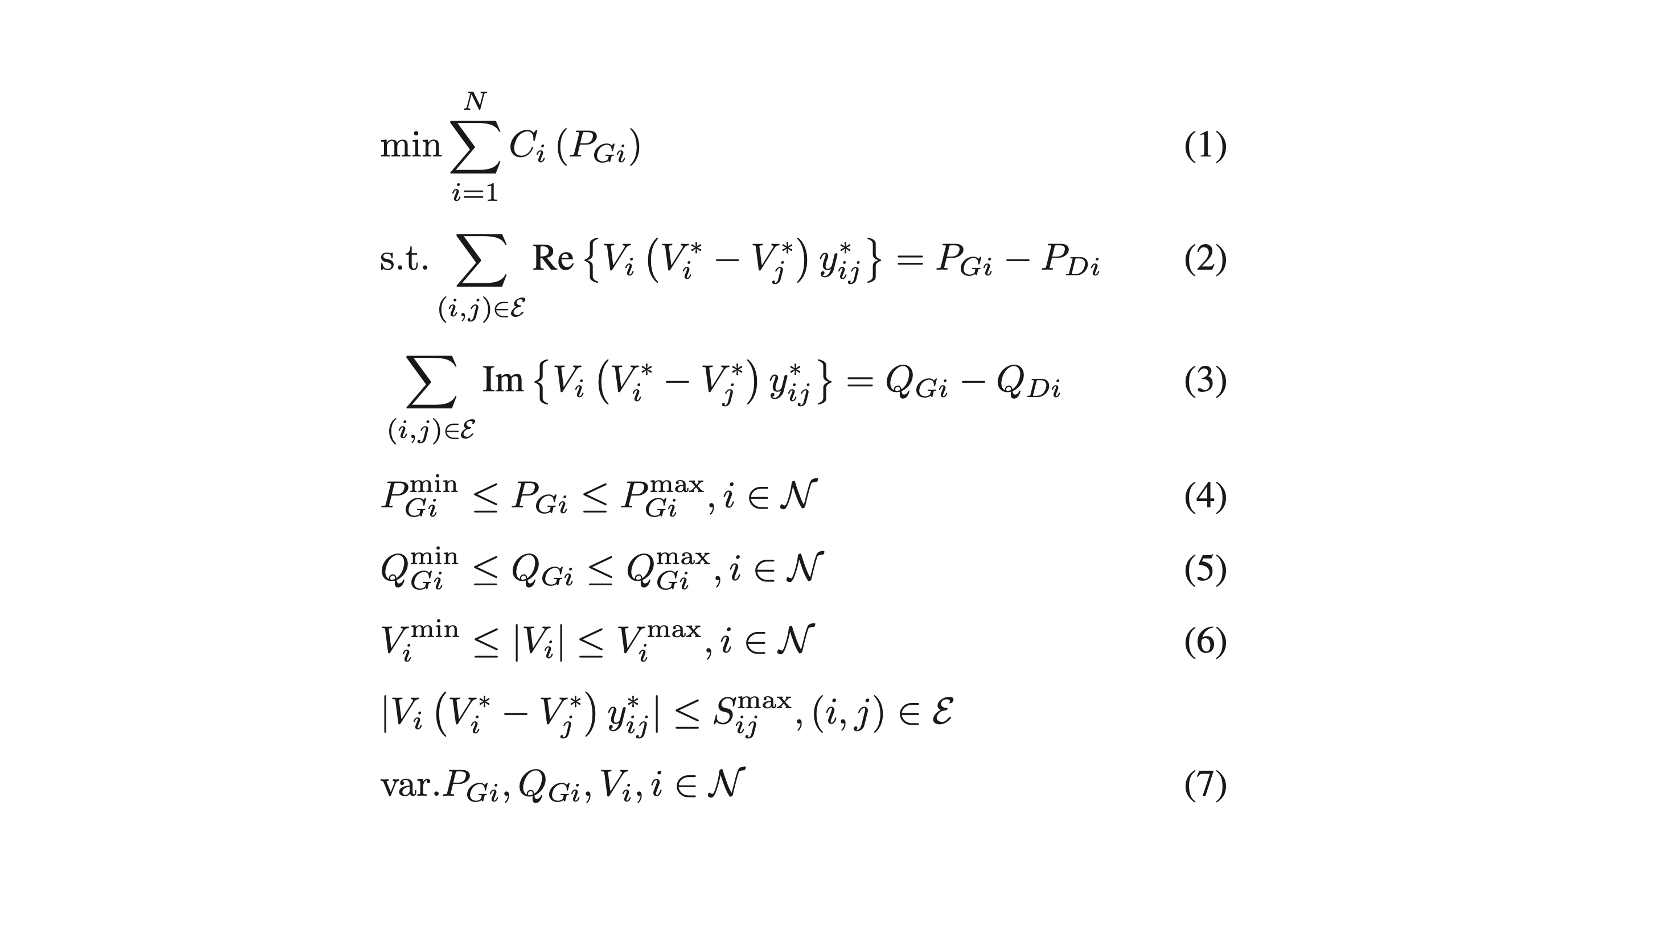



#### Variables and parameters

* **$P_{G_i}$**: Active power at generator i
* **$Q_{G_i}$**: Reactive power at generator i
* **$P_{D_i}$**: Active power demand load at bus i
* **$G_{D_i}$**: Reactive power demand load at bus i
* **$V_i$**: Voltage magnitude at bus i
* **$S_{ij}$**: Complex power from bus i to j, where
    * $S_{ij} =  P_{ij} + jQ_{ij}$
* **$Y_{ij}$**: Admittance of line ij,where 
    * $Y = G  + jB$
    * G(conductance): Measures the ability of the line to conduct electric current. It represents the real part of the admittance and indicates the power dissipation in the line due to resistance. Higher conductance implies lower energy losses.
    * B(Susceptance): Represents the imaginary part of admittance and is crucial for understanding the capacitive or inductive nature of the line. Susceptance affects the reactive power flow and voltage regulation across the line.


#### Constraints

- **Objective function** (Equation 1):
The objective is to minimize the sum of the costs associated with the real power generation at each bus.
- **Power flow constraints** (Equations 2 and 3):
These constraints ensure that the real and reactive power balance is maintained at each bus, accounting for the complex power flows in the network.
- **Variable bounds** (Equations 4-6):
These constraints impose limits on the real and reactive power generation, as well as the voltage magnitudes at each bus, to ensure the feasibility of the solution.
- **Apparent power flow limit** (Equation 6):
This constraint limits the <i>apparent power</i> flow (i.e., magnitude of the complex power flow) through each transmission line or transformer to a maximum value, ensuring that the system operates within its physical limits.
- **Optimization variables** (Equation 7):
The optimization variables in this formulation are the real and reactive power generation, and the complex voltage (magnitude and angle).

### Import libraries and dependencies

In [1]:
import time
from os.path import join
import numpy as np
from read_data_pglib import read_matpower_powergrid

# import the solver and solver options from pypower
from pypower.api import runopf, ppoption
from pypower.loadcase import loadcase
from pypower.ext2int import ext2int
from pypower.makeYbus import makeYbus

### Prepare Data

We can read the test data in two ways:

* Use  the `read_data_pglib.py` file to execute the .m files
* Use the test cases from the Pypower library

In [2]:
dir_myFile = r'test data/PGLib OPF/feasible'
net = read_matpower_powergrid(dir_myFile)
net

{'baseMVA': 100.0,
 'bus': array([[  1.  ,   2.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  , 230.  ,   1.  ,   1.1 ,   0.9 ],
        [  2.  ,   1.  , 300.  ,  98.61,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  , 230.  ,   1.  ,   1.1 ,   0.9 ],
        [  3.  ,   2.  , 300.  ,  98.61,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  , 230.  ,   1.  ,   1.1 ,   0.9 ],
        [  4.  ,   3.  , 400.  , 131.47,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  , 230.  ,   1.  ,   1.1 ,   0.9 ],
        [  5.  ,   2.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  , 230.  ,   1.  ,   1.1 ,   0.9 ]]),
 'gen': array([[   1. ,   20. ,    0. ,   30. ,  -30. ,    1. ,  100. ,    1. ,
           40. ,    0. ],
        [   1. ,   85. ,    0. ,  127.5, -127.5,    1. ,  100. ,    1. ,
          170. ,    0. ],
        [   3. ,  260. ,    0. ,  390. , -390. ,    1. ,  100. ,    1. ,
          520. ,    0. ],
        [   4. ,  100. ,    0. ,  150. , -150. ,    1

In [3]:
caseFile = join('C:/Users/Ruben/anaconda3/envs/pytorch/Lib/site-packages/pypower', 'case14')
# load a test power system
net2 = loadcase(caseFile)
# convert to internal numbering, remove out-of-service stuff 
net2 = ext2int(net2)
net2

{'version': '2',
 'baseMVA': 100.0,
 'bus': array([[  0.   ,   3.   ,   0.   ,   0.   ,   0.   ,   0.   ,   1.   ,
           1.06 ,   0.   ,   0.   ,   1.   ,   1.06 ,   0.94 ],
        [  1.   ,   2.   ,  21.7  ,  12.7  ,   0.   ,   0.   ,   1.   ,
           1.045,  -4.98 ,   0.   ,   1.   ,   1.06 ,   0.94 ],
        [  2.   ,   2.   ,  94.2  ,  19.   ,   0.   ,   0.   ,   1.   ,
           1.01 , -12.72 ,   0.   ,   1.   ,   1.06 ,   0.94 ],
        [  3.   ,   1.   ,  47.8  ,  -3.9  ,   0.   ,   0.   ,   1.   ,
           1.019, -10.33 ,   0.   ,   1.   ,   1.06 ,   0.94 ],
        [  4.   ,   1.   ,   7.6  ,   1.6  ,   0.   ,   0.   ,   1.   ,
           1.02 ,  -8.78 ,   0.   ,   1.   ,   1.06 ,   0.94 ],
        [  5.   ,   2.   ,  11.2  ,   7.5  ,   0.   ,   0.   ,   1.   ,
           1.07 , -14.22 ,   0.   ,   1.   ,   1.06 ,   0.94 ],
        [  6.   ,   1.   ,   0.   ,   0.   ,   0.   ,   0.   ,   1.   ,
           1.062, -13.37 ,   0.   ,   1.   ,   1.06 ,   0.94 ],
     

We will work with the case5_pjm moving forward

### Use PyPower to solve the AC-OPF problem (Feasible values)

In [4]:
# Run power flow to get results
option = ppoption(OUT_ALL=-1) # set the output details
result = runopf(net, option) # run the ACOPF

PYPOWER Version 5.1.17, 02-Sept-2024 -- AC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Numerically failed.
Did not converge in 2 iterations.

Did not converge (0.09 seconds)

Objective Function Value = 13007.90 $/hr
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses              5     Total Gen Capacity    1530.0       -1147.5 to 1147.5
Generators         5     On-line Capacity      1530.0       -1147.5 to 1147.5
Committed Gens     5     Generation (actual)    498.7              79.1
Loads              3     Load                  1000.0             328.7
  Fixed            3       Fixed               1000.0             328.7
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             0     Shunt (inj)              0.0              

### ADMM algorithm

The ADMM algorithm is a distributed optimization algorithm that combines the best of both worlds:
it uses the computational power of each machine to find an optimal solution, while also ensuring that
the global solution is meaningful.
The algorithm can be thought of as a **two-step process** parameterized by the learning rate 𝜂 > 0 and
a multiplier 𝜆 > 0, as follows. We will use the same steps to implement the ADMM algorithm to **solve the AC-OPF of our specific test case** 

![Alt text](media/admm_image.png)

We will use the same steps to implement the ADMM algorithm to **solve the AC-OPF of our specific test case** 

## ADMM Algorithm Steps

The ADMM algorithm iteratively updates the local variables, shared variables, and dual variables until convergence.

### Initialization

1. **Initialize Local Variables:** Set initial guesses for $( x_m^0 )$ at each machine ($m$).
2. **Initialize Shared Variables:** Set initial values for $( z^0 )$, possibly by averaging local variables.
3. **Initialize Dual Variables:** Set $(\lambda_m^0 = 0)$ for all machines.
4. **Set Penalty Parameter:** Choose an appropriate value for $(\rho)$.

### Local Variable Update

Each machine $(m)$ solves the following optimization problem independently:

$$
x_m^{k+1} = \arg\min_{x_m} \left\{ f_m(x_m) + \lambda_m^{k \, \top} (A_m x_m - z_m^k) + \frac{\rho}{2} \| A_m x_m - z_m^k \|^2 \right\}
$$

- **Purpose:** Minimize the local augmented Lagrangian with respect to local variables $( x_m )$, given the current shared variables $(z_m^k)$ and dual variables $(\lambda_m^k)$.

### Shared Variable Update

The orchestrator (or central coordinator) updates the shared variables by minimizing the augmented Lagrangian with respect to $(z)$:

$$
z^{k+1} = \arg\min_{z} \left\{ \sum_{m} \left( -\lambda_m^{k \, \top} z_m + \frac{\rho}{2} \| A_m x_m^{k+1} - z_m \|^2 \right) \right\}
$$

- **Simplification:** Often results in averaging the local variables and adjusting based on dual variables.

### Dual Variable Update

Each machine updates its dual variables:

$$
\lambda_m^{k+1} = \lambda_m^{k} + \rho (A_m x_m^{k+1} - z_m^{k+1})
$$

- **Purpose:** Adjust the dual variables to penalize any discrepancy between the local variables and the shared variables, enforcing consensus.

### Iteration and Convergence

- **Repeat:** The steps of local variable update, shared variable update, and dual variable update are repeated until convergence criteria are met.
- **Convergence Criteria:** Based on the norms of primal and dual residuals falling below predefined thresholds.


#### Bus Voltages magnitudes and angles
Extracting $V_i$ and $\theta_i$ from the solution using Pypower

In [5]:
# Extract bus data
bus_data = result['bus']

# Bus numbers
bus_numbers = bus_data[:, 0].astype(int)

# Voltage magnitude V_i (per unit)
V_i = bus_data[:, 7]  # VM column

# Voltage angle θ_i (degrees)
theta_i = bus_data[:, 8]  # VA column

#### Generator outputs

Extracting $P_{G_i}$ and $Q_{G_i}$

In [6]:
# Extract generator data
gen_data = result['gen']

# Initialize arrays for PG_i and QG_i
num_buses = bus_data.shape[0]
PG_i = result['gen'][:, 1]
QG_i = result['gen'][:, 2]


#### Power Flows Between Buses

Extracting $P_{ij}$ and $Q_{ij}$

In [7]:



branch_data = result['branch']

# Extract bus numbers and create a mapping to indices
bus_numbers = bus_data[:, 0].astype(int)
num_buses = bus_numbers.size
bus_number_to_index = {bus_num: idx for idx, bus_num in enumerate(bus_numbers)}

# Initialize Pij and Qij matrices with zeros
Pij_matrix = np.zeros((num_buses, num_buses))
Qij_matrix = np.zeros((num_buses, num_buses))

# Loop over each branch to populate the matrices
for branch in branch_data:
    from_bus = int(branch[0])
    to_bus = int(branch[1])
    
    from_idx = bus_number_to_index[from_bus]
    to_idx = bus_number_to_index[to_bus]
    
    # Power flow from "from_bus" to "to_bus"
    P_from_to = branch[13]  # PF column
    Q_from_to = branch[14]  # QF column
    
    # Power flow from "to_bus" to "from_bus"
    P_to_from = branch[15]  # PT column
    Q_to_from = branch[16]  # QT column
    
    # Populate the matrices
    Pij_matrix[from_idx, to_idx] = P_from_to
    Qij_matrix[from_idx, to_idx] = Q_from_to
    
    Pij_matrix[to_idx, from_idx] = P_to_from
    Qij_matrix[to_idx, from_idx] = Q_to_from



In [8]:
print("Variable values from Pypower:")
print(f'\n\t* P_Gi: {PG_i}')
print(f'\n\t* Q_Gi: {QG_i}')
print(f'\n\t* V_i: {V_i}')
print(f'\n\t* theta_i: {theta_i}')
# Print Pij_matrix with bus numbers
print("\nPij Matrix (Real Power Flows):")
print("     " + "  ".join(f"{bus_num:>5}" for bus_num in bus_numbers))
for idx_i, bus_i in enumerate(bus_numbers):
    row_values = "  ".join(f"{Pij_matrix[idx_i, idx_j]:>8.2f}" for idx_j in range(num_buses))
    print(f"{bus_i:>5} {row_values}")

# Similarly for Qij_matrix
print("\nQij Matrix (Reactive Power Flows):")
print("     " + "  ".join(f"{bus_num:>5}" for bus_num in bus_numbers))
for idx_i, bus_i in enumerate(bus_numbers):
    row_values = "  ".join(f"{Qij_matrix[idx_i, idx_j]:>8.2f}" for idx_j in range(num_buses))
    print(f"{bus_i:>5} {row_values}")

Variable values from Pypower:

	* P_Gi: [-18.00617539  46.61995707 276.98948195  77.32715839 115.79209668]

	* Q_Gi: [ 3.07970875  3.92621935 63.23217653  8.55785584  0.2744357 ]

	* V_i: [1.03812022 1.32778606 0.83358729 1.11409148 0.83441409]

	* theta_i: [  34.25868985  -20.49820551    0.3335975    -8.86273092 -261.04578754]

Pij Matrix (Real Power Flows):
         1      2      3      4      5
    1     0.00   4066.05      0.00   2650.84  -11020.46
    2 -3625.65      0.00  -2940.61      0.00      0.00
    3     0.00   3297.17      0.00    420.82      0.00
    4 -2445.48      0.00   -386.63      0.00  -2441.79
    5 12619.23      0.00      0.00   3277.32      0.00

Qij Matrix (Reactive Power Flows):
         1      2      3      4      5
    1     0.00    597.61      0.00    502.69  12154.20
    2  3805.40      0.00   7038.22      0.00      0.00
    3     0.00  -3474.83      0.00   -789.41      0.00
    4  1550.12      0.00   1130.65      0.00   5380.60
    5  3830.72      0.00    

Now that we have initial values for $P_{G_i}$, $Q_{G_i}$, $V_i$, $\theta_i$, $P_{ij}$ and $Q_{ij}$, we can start to implement the algorithm

In [9]:
PG_i

array([-18.00617539,  46.61995707, 276.98948195,  77.32715839,
       115.79209668])

In [10]:

# Compute xm


# Convert theta_i from degrees to radians for calculations
theta_i = np.radians(theta_i)

# Flatten Pij and Qij matrices
Pij_flat = Pij_matrix.flatten()
Qij_flat = Qij_matrix.flatten()

# Combine all variables into x_m
x_m = np.concatenate([PG_i, QG_i, V_i, theta_i, Pij_flat, Qij_flat])
x_m

array([-1.80061754e+01,  4.66199571e+01,  2.76989482e+02,  7.73271584e+01,
        1.15792097e+02,  3.07970875e+00,  3.92621935e+00,  6.32321765e+01,
        8.55785584e+00,  2.74435698e-01,  1.03812022e+00,  1.32778606e+00,
        8.33587293e-01,  1.11409148e+00,  8.34414093e-01,  5.97926935e-01,
       -3.57761177e-01,  5.82237482e-03, -1.54683835e-01, -4.55610849e+00,
        0.00000000e+00,  4.06604714e+03,  0.00000000e+00,  2.65084218e+03,
       -1.10204646e+04, -3.62564522e+03,  0.00000000e+00, -2.94060521e+03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  3.29717130e+03,
        0.00000000e+00,  4.20818533e+02,  0.00000000e+00, -2.44548452e+03,
        0.00000000e+00, -3.86629620e+02,  0.00000000e+00, -2.44179212e+03,
        1.26192338e+04,  0.00000000e+00,  0.00000000e+00,  3.27731808e+03,
        0.00000000e+00,  0.00000000e+00,  5.97606769e+02,  0.00000000e+00,
        5.02692645e+02,  1.21541986e+04,  3.80540117e+03,  0.00000000e+00,
        7.03821649e+03,  

In [11]:

# Total number of buses
num_buses = int(np.max(result['bus'][:, 0]))  # Bus numbers start from 1

# Initialize neighbors_list
neighbors_list = [[] for _ in range(num_buses)]

# Extract from and to buses
from_buses = branch_data[:, 0].astype(int) - 1  # Zero-based indexing
to_buses = branch_data[:, 1].astype(int) - 1

# Build neighbors_list
for f_bus, t_bus in zip(from_buses, to_buses):
    neighbors_list[f_bus].append(t_bus)
    neighbors_list[t_bus].append(f_bus)  # Since the network is undirected



In [12]:
gen_data = result['gen']
gencost_data = result['gencost']

# Map generator indices to bus indices
gen_buses = gen_data[:, 0].astype(int) - 1  # Zero-based indexing

gen_costs = {}
for idx, bus in enumerate(gen_buses):
    # Extract cost coefficients
    cost_row = gencost_data[idx]
    model = cost_row[0]
    n = int(cost_row[3])  # Number of cost coefficients
    coefficients = cost_row[4:4 + n]
    # For quadratic cost function: coefficients are [c_n, ..., c_0]
    # We need to extract 'a' and 'b' for the quadratic cost function a*P^2 + b*P + c

    # Assuming cost model is polynomial (model == 2)
    if n == 3:
        c0, c1, c2 = coefficients
        gen_costs[bus] = {'a': c0, 'b': c1, 'c': c2}
    else:
        # Handle other cost models as needed
        pass

gen_costs

{0: {'a': 0.0, 'b': 15.0, 'c': 0.0},
 2: {'a': 0.0, 'b': 30.0, 'c': 0.0},
 3: {'a': 0.0, 'b': 40.0, 'c': 0.0},
 4: {'a': 0.0, 'b': 10.0, 'c': 0.0}}

In [13]:
gen_data = result['gen']
gencost_data = result['gencost']
gen_buses = gen_data[:, 0].astype(int) - 1  # Zero-based indexing
num_buses = int(np.max(result['bus'][:, 0]))
gen_costs = {bus: [] for bus in range(num_buses)}  # Initialize all buses

for idx, bus in enumerate(gen_buses):
    cost_row = gencost_data[idx]
    model = cost_row[0]
    n = int(cost_row[3])
    coefficients = cost_row[4:4 + n]
    if model == 2 and n == 3:
        c2, c1, c0 = coefficients
        gen_costs[bus].append({'a': c2, 'b': c1, 'c': c0})
    else:
        # Handle other models if necessary
        pass

gen_costs

{0: [{'a': 0.0, 'b': 14.0, 'c': 0.0}, {'a': 0.0, 'b': 15.0, 'c': 0.0}],
 1: [],
 2: [{'a': 0.0, 'b': 30.0, 'c': 0.0}],
 3: [{'a': 0.0, 'b': 40.0, 'c': 0.0}],
 4: [{'a': 0.0, 'b': 10.0, 'c': 0.0}]}

In [14]:
gen_limits = {}
for idx, bus in enumerate(gen_buses):
    gen = gen_data[idx]
    PG_min = gen[9]  # Minimum real power output (last column)
    PG_max = gen[8]  # Maximum real power output
    QG_min = gen[3]  # Minimum reactive power output
    QG_max = gen[4]  # Maximum reactive power output
    gen_limits[bus] = {
        'PG_min': PG_min,
        'PG_max': PG_max,
        'QG_min': QG_min,
        'QG_max': QG_max
    }


gen_limits

{0: {'PG_min': 0.0, 'PG_max': 170.0, 'QG_min': 127.5, 'QG_max': -127.5},
 2: {'PG_min': 0.0, 'PG_max': 520.0, 'QG_min': 390.0, 'QG_max': -390.0},
 3: {'PG_min': 0.0, 'PG_max': 200.0, 'QG_min': 150.0, 'QG_max': -150.0},
 4: {'PG_min': 0.0, 'PG_max': 600.0, 'QG_min': 450.0, 'QG_max': -450.0}}

In [15]:
gen_data = result['gen']
gen_buses = gen_data[:, 0].astype(int) - 1  # Zero-based indexing
num_buses = int(np.max(result['bus'][:, 0]))
gen_limits = {bus: [] for bus in range(num_buses)}  # Initialize all buses

for idx, bus in enumerate(gen_buses):
    gen = gen_data[idx]
    PG_max = gen[8]  # Maximum real power output
    PG_min = gen[9]  # Minimum real power output
    QG_max = gen[3]  # Maximum reactive power output
    QG_min = gen[4]  # Minimum reactive power output
    gen_limits[bus].append({
            'PG_min': PG_min,
            'PG_max': PG_max,
            'QG_min': QG_min,
            'QG_max': QG_max
    }) 

gen_limits

{0: [{'PG_min': 0.0, 'PG_max': 40.0, 'QG_min': -30.0, 'QG_max': 30.0},
  {'PG_min': 0.0, 'PG_max': 170.0, 'QG_min': -127.5, 'QG_max': 127.5}],
 1: [],
 2: [{'PG_min': 0.0, 'PG_max': 520.0, 'QG_min': -390.0, 'QG_max': 390.0}],
 3: [{'PG_min': 0.0, 'PG_max': 200.0, 'QG_min': -150.0, 'QG_max': 150.0}],
 4: [{'PG_min': 0.0, 'PG_max': 600.0, 'QG_min': -450.0, 'QG_max': 450.0}]}

In [16]:
bus_data = result['bus']

voltage_limits = {}
for idx, bus_row in enumerate(bus_data):
    bus_idx = int(bus_row[0]) - 1  # Zero-based indexing
    V_min = bus_row[12]  # Minimum voltage magnitude
    V_max = bus_row[11]  # Maximum voltage magnitude
    voltage_limits[bus_idx] = {
        'V_min': V_min,
        'V_max': V_max
    }


In [17]:
from admm import *

In [18]:
# Define number of buses
num_buses = int(np.max(result['bus'][:, 0]))

# Ensure all buses are present in gen_costs and gen_limits
for bus in range(num_buses):
    if bus not in gen_costs:
        gen_costs[bus] = []  # No generators at this bus
    if bus not in gen_limits:
        gen_limits[bus] = []  # No generator limits at this bus

In [19]:
# Define network data structure
network_data = {
    'num_buses': num_buses,
    'neighbors': neighbors_list,  # List of neighbors for each bus
    'gen_costs': gen_costs,        # Generation cost coefficients for each generator
    'gen_limits': gen_limits,     # Generator limits for each bus
    'voltage_limits': voltage_limits,  # Voltage limits for each bus
    # Add other necessary data (line impedances, loads, etc.)
}

# Initialize x_m as a dictionary
x_m_init = {
    'PG_i': PG_i.copy(),
    'QG_i': QG_i.copy(),
    'V_i': V_i.copy(),
    'theta_i': theta_i.copy(),
    'Pij': Pij_matrix.copy(),
    'Qij': Qij_matrix.copy()
}

network_data


{'num_buses': 5,
 'neighbors': [[1, 3, 4], [0, 2], [1, 3], [0, 2, 4], [0, 3]],
 'gen_costs': {0: [{'a': 0.0, 'b': 14.0, 'c': 0.0},
   {'a': 0.0, 'b': 15.0, 'c': 0.0}],
  1: [],
  2: [{'a': 0.0, 'b': 30.0, 'c': 0.0}],
  3: [{'a': 0.0, 'b': 40.0, 'c': 0.0}],
  4: [{'a': 0.0, 'b': 10.0, 'c': 0.0}]},
 'gen_limits': {0: [{'PG_min': 0.0,
    'PG_max': 40.0,
    'QG_min': -30.0,
    'QG_max': 30.0},
   {'PG_min': 0.0, 'PG_max': 170.0, 'QG_min': -127.5, 'QG_max': 127.5}],
  1: [],
  2: [{'PG_min': 0.0, 'PG_max': 520.0, 'QG_min': -390.0, 'QG_max': 390.0}],
  3: [{'PG_min': 0.0, 'PG_max': 200.0, 'QG_min': -150.0, 'QG_max': 150.0}],
  4: [{'PG_min': 0.0, 'PG_max': 600.0, 'QG_min': -450.0, 'QG_max': 450.0}]},
 'voltage_limits': {0: {'V_min': 0.9, 'V_max': 1.1},
  1: {'V_min': 0.9, 'V_max': 1.1},
  2: {'V_min': 0.9, 'V_max': 1.1},
  3: {'V_min': 0.9, 'V_max': 1.1},
  4: {'V_min': 0.9, 'V_max': 1.1}}}

In [21]:
# Run the ADMM algorithm
x_m_final, z_final, lambda_m_final = admm_algorithm(x_m_init, network_data, rho=1.0, max_iter=100, tol=1e-4)

Iteration 1
Converged in 1 iterations.
Converged in 1 iterations.
Converged in 1 iterations.
Converged in 1 iterations.
Converged in 1 iterations.
Convergence achieved.


In [23]:
x_m_final

{'PG_i': array([  0.        ,   0.        , 276.38948195,  76.52715839,
        115.59209668]),
 'QG_i': array([ 3.07970875,  0.        , 63.23217653,  8.55785584,  0.2744357 ]),
 'V_i': array([1.03812022, 1.1       , 0.9       , 1.1       , 0.9       ]),
 'theta_i': array([ 0.59792694, -0.35776118,  0.00582237, -0.15468384, -3.14159265]),
 'Pij': array([[     0.        ,   3985.13280502,      0.        ,
           2598.09042259, -10801.15739664],
        [ -3553.49487978,      0.        ,  -2882.08716858,
              0.        ,      0.        ],
        [     0.        ,   3231.55758686,      0.        ,
            412.44424417,      0.        ],
        [ -2396.81938109,      0.        ,   -378.93569016,
              0.        ,  -2393.2004532 ],
        [ 12368.11104687,      0.        ,      0.        ,
           3212.09944611,      0.        ]]),
 'Qij': array([[    0.        ,   585.71439425,     0.        ,   492.68906151,
         11912.33009685],
        [ 3729.67369033


## Summary of the Approach

The ADMM implementation for the AC-OPF problem involves the following key components:

1. **Decomposition of the Global Problem:**
   - The global AC-OPF problem is decomposed into local subproblems corresponding to individual machines (generators or buses).

2. **Local Optimization:**
   - Each machine solves its own optimization problem, considering local constraints and objectives, and updates its local variables.

3. **Shared Variables and Consensus:**
   - Power flows between buses are treated as shared variables requiring consensus.
   - The orchestrator ensures that the shared variables are updated consistently across the network.

4. **Dual Variables and Augmented Lagrangian:**
   - Dual variables are used to enforce consensus constraints.
   - The augmented Lagrangian incorporates penalty terms to penalize discrepancies between local and shared variables.

5. **Iterative Updates via ADMM:**
   - The algorithm iteratively updates local variables, shared variables, and dual variables.
   - Convergence is achieved when the solutions are consistent and optimal across the entire network.



Basic system configuration

### Compare results